In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

from sklearn import metrics, preprocessing

import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import Lasso, Ridge, SGDRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

import seaborn as sb
%matplotlib inline

In [2]:
df = pd.read_csv("chrolophylldata_with_geocoding_and_weather.csv")
cols = ['Date2','Latitude','Longitude','Chlorophyll', 'pH', 'Temperature', 'P', 'DissolvedOxygen', 'ElecticalConductivity','Turbidity','N']
data = df[cols]
data = data.dropna()

#data=data[data["Chlorophyll"]<=50]

col = data.pop("Chlorophyll")
data.insert(0, col.name, col)   

data = data.query('Chlorophyll < Chlorophyll.quantile(.75)')
data = data.query('Chlorophyll > Chlorophyll.quantile(.25)')

# data = data.query('P < P.quantile(.75)')
# data = data.query('P > P.quantile(.25)')

# for c in data.columns:
#     data = data.query(f'{c} < {c}.quantile(.75)')
#     data = data.query(f'{c} > {c}.quantile(.25)')
#     print(data.shape)


print(data.shape)
data.describe()

(145, 11)


,Chlorophyll,Date2,Latitude,Longitude,pH,Temperature,P,DissolvedOxygen,ElecticalConductivity,Turbidity,N
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,13.198621,188.131034,56.044766,13.359111,7.665034,12.188966,38.070345,10.815172,23.122000,4.266552,1351.724138
std,7.129769,88.786906,0.211365,0.185720,0.586762,6.568624,73.473811,1.744250,9.903547,2.578800,604.526151
min,4.100000,14.000000,55.483214,13.040853,6.380000,0.600000,5.000000,6.700000,7.500000,0.900000,410.000000
25%,6.700000,133.000000,55.892097,13.277489,7.200000,5.500000,18.000000,9.600000,10.900000,2.600000,900.000000
50%,12.000000,194.000000,56.094148,13.307880,7.660000,12.800000,27.000000,10.600000,25.500000,3.600000,1300.000000
75%,19.000000,230.000000,56.278749,13.548270,8.100000,18.300000,38.000000,12.000000,29.300000,5.300000,1700.000000
max,27.000000,349.000000,56.354940,13.976081,9.040000,22.900000,880.000000,15.800000,51.900000,16.000000,4100.000000


#### 1.0 Multiple Regression
##### Scaling

In [3]:
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(data)
scaled_data = pd.DataFrame(d, columns=data.columns)

scaled_data = scaled_data.query('Chlorophyll < Chlorophyll.quantile(.75)')
scaled_data = scaled_data.query('Chlorophyll > Chlorophyll.quantile(.25)')

print(scaled_data)


     Chlorophyll     Date2  Latitude  Longitude        pH  Temperature   
2       0.109170  0.626866  0.700832   0.270848  0.353383     0.914798  \
3       0.563319  0.626866  0.912598   0.285521  0.281955     0.901345   
4       0.344978  0.979104  0.469049   0.463998  0.676692     0.215247   
6       0.606987  0.352239  0.469049   0.463998  0.687970     0.538117   
10      0.606987  0.811940  0.447468   0.542560  0.605263     0.426009   
..           ...       ...       ...        ...       ...          ...   
139     0.113537  0.635821  0.956697   0.066694  0.278195     0.771300   
140     0.183406  0.358209  0.956697   0.066694  0.398496     0.614350   
141     0.152838  0.632836  0.956697   0.066694  0.451128     0.865471   
143     0.152838  0.376119  0.956697   0.066694  0.308271     0.623318   
144     0.257642  0.626866  0.956697   0.066694  0.872180     0.807175   

            P  DissolvedOxygen  ElecticalConductivity  Turbidity         N  
2    0.026286         0.153846    

In [4]:
print(scaled_data.shape)
scaled_data.describe()


(79, 11)


,Chlorophyll,Date2,Latitude,Longitude,pH,Temperature,P,DissolvedOxygen,ElecticalConductivity,Turbidity,N
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,0.320104,0.534102,0.664266,0.323235,0.472019,0.565306,0.030932,0.421755,0.345290,0.196119,0.234880
std,0.170726,0.247314,0.229932,0.187686,0.202621,0.278665,0.022816,0.201887,0.223039,0.144298,0.153369
min,0.087336,0.000000,0.000000,0.000000,0.000000,0.008969,0.000000,0.000000,0.007658,0.000000,0.002710
25%,0.157205,0.358209,0.469049,0.253025,0.319549,0.374439,0.017143,0.285714,0.076577,0.112583,0.127371
50%,0.301310,0.623881,0.700832,0.285521,0.451128,0.578475,0.024000,0.373626,0.405405,0.158940,0.241192
75%,0.475983,0.634328,0.912598,0.542560,0.629699,0.804933,0.040000,0.549451,0.490991,0.248344,0.322493
max,0.606987,1.000000,0.960768,0.545185,0.947368,1.000000,0.154286,1.000000,0.948198,1.000000,1.000000


##### Splitting Data

In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(
    scaled_data[['Date2', 'pH','Latitude','Longitude', 'Temperature', 'P', 'DissolvedOxygen', 'ElecticalConductivity','Turbidity','N']],
    scaled_data[["Chlorophyll"]],
    test_size=0.2,
    random_state=0
    )
print (f"Training Set Size: {X_train.shape[0]}")
print (f"Test Set Size: {X_test.shape[0]}")

Training Set Size: 63
Test Set Size: 16


##### Linear Regression with sklearn

In [6]:
lr = LinearRegression(fit_intercept=True)
pr=lr.fit(X_train,Y_train)
print(f'R-Squared (train): {lr.score(X_train, Y_train)}')
print(f'R-Squared (test): {lr.score(X_test, Y_test)}')
print(f'Coefficient: {lr.coef_}')
print(f'Intercept: {lr.intercept_}')

R-Squared (train): 0.4207244934543062
R-Squared (test): 0.043412228028307576
Coefficient: [[-0.18846939  0.05325993  0.16754157  0.17858813  0.00581705  1.55363363
  -0.04112015  0.4574359   0.33843691 -0.64275015]]
Intercept: [0.12406635]


In [7]:
pipe = Pipeline([    
    # ('scale', preprocessing.StandardScaler()),
    ('regr', LinearRegression())
])

param_grid = [
    {
        'regr': [Lasso(), Ridge()],
        'regr__alpha': np.logspace(-4, 1, 6),
    },
    {
        'regr': [SGDRegressor()],
        'regr__alpha': np.logspace(-5, 0, 6),
        'regr__max_iter': [500, 1000],
    },
]
# grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# grid.fit(X_train, Y_train)
# print(f'R-Squared (train): {lr.score(X_train, Y_train)}')
# print(f'R-Squared (test): {lr.score(X_test, Y_test)}')
# print(f'Coefficient: {lr.coef_}')
# print(f'Intercept: {lr.intercept_}')

In [8]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_train_pca = sm.add_constant(X_train_pca)
smmodel = sm.OLS(Y_train,X_train_pca).fit()
print("Fit Parameters:")
print(smmodel.params)
print()
smmodel.summary()

Fit Parameters:
const    0.328273
x1      -0.119560
x2       0.187736
x3       0.005102
dtype: float64



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Chlorophyll   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     4.981
Date:                Sat, 06 May 2023   Prob (F-statistic):            0.00379
Time:                        12:17:10   Log-Likelihood:                 30.376
No. Observations:                  63   AIC:                            -52.75
Df Residuals:                      59   BIC:                            -44.18
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3283      0.019     16.877      0.000       0.289       0.367
x1            -0.1196      0.045     -2.671      0.010      -0.209      -0.030
x2             0.1877      0.067      2.794      0.007       0.053       0.322
x3             0.0051      0.080      0.064      0.949      -0.154       0.165
==============================================================================
Omnibus:                       10.261   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                3.126
Skew:                           0.084   Prob(JB):                        0.210
Kurtosis:                       1.922   Cond. No.                         4.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Predict

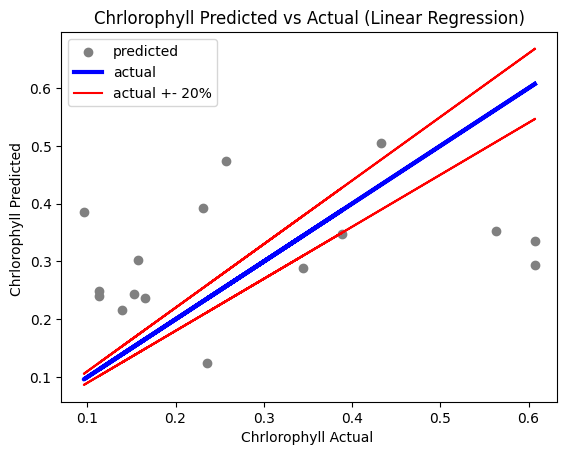

In [9]:
X_test_pca = pca.fit_transform(X_test)
X_test_pca = sm.add_constant(X_test_pca)

Y_pred = pr.predict(X_test )
plt.scatter(Y_test,Y_pred,color='gray', label='predicted')
plt.plot(Y_test,Y_test,color='blue', linewidth=3, label='actual')
plt.plot(Y_test,Y_test*1.1,color='red', linewidth=1.5, label='actual +- 20%')
plt.plot(Y_test,Y_test*0.9,color='red', linewidth=1.5 )
plt.title('Chrlorophyll Predicted vs Actual (Linear Regression)')  
plt.xlabel('Chrlorophyll Actual ')  
plt.ylabel('Chrlorophyll Predicted ')  
plt.legend(loc="upper left")

In [10]:
degree=2
poly_model = PolynomialFeatures(degree=degree)
poly_x_values = poly_model.fit_transform(X_train)
poly_model.fit(poly_x_values, Y_train)
regression_model = LinearRegression()
regression_model.fit(poly_x_values, Y_train)
y_pred = regression_model.predict(poly_x_values)
print(regression_model.coef_)
mean_squared_error(Y_train, y_pred, squared=False)



[[ 1.01351316e-10  6.12364017e+01  1.22307031e+01  9.95768733e+01
   3.13527324e+01  1.24202301e+01  8.29181321e+01  2.59504212e+01
   5.07698429e+01 -1.13254160e+01 -9.25982511e+01  7.89265390e+00
  -2.78100610e+01 -8.41700387e+01 -5.95926904e+01  2.49919091e+01
  -6.15955751e+01  1.94257616e+01 -1.13575647e+01  9.45018880e-01
   1.79589080e+01  1.75925142e+01  1.44874145e+00 -1.51764169e+01
  -3.32054292e+00  3.95922842e+01 -3.78466710e+01  1.41475791e+01
  -4.16803122e+00  1.97803349e+01 -1.05636275e+01  3.35864991e+01
  -4.04714477e+01 -1.46886534e+02 -4.78755152e+01 -1.93863637e+01
  -6.87830811e+00  6.22809297e+01  1.68033933e+00 -3.12752061e+01
  -1.12846436e-01 -1.43311519e+01  2.13085728e+00  1.91938838e+01
   5.68898285e+01  3.08483295e+00  5.91105561e+01  1.80844329e+01
  -1.60501839e+01  1.48735729e+01  9.20693304e+00 -3.81349551e+01
   9.76438822e+01 -5.69618021e+01 -2.61627724e+01 -8.14774084e+01
   1.05569030e+01 -2.52852720e+01  8.81789247e+00  1.16021200e+01
  -1.20262

2.972598454103872e-14

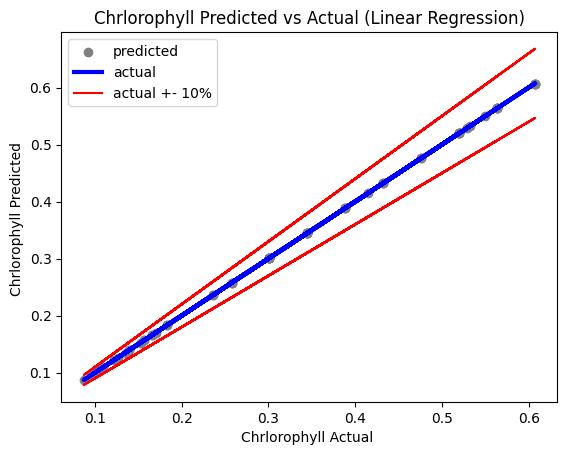

In [11]:
poly_x_values = poly_model.fit_transform(X_train)
poly_model.fit(poly_x_values, Y_train)
Y_pred = regression_model.predict(poly_x_values )
plt.scatter(Y_train,Y_pred,color='gray', label='predicted')
plt.plot(Y_train,Y_train,color='blue', linewidth=3, label='actual')
plt.plot(Y_train,Y_train*1.1,color='red', linewidth=1.5, label='actual +- 10%')
plt.plot(Y_train,Y_train*0.9,color='red', linewidth=1.5 )
plt.title('Chrlorophyll Predicted vs Actual (Linear Regression)')  
plt.xlabel('Chrlorophyll Actual ')  
plt.ylabel('Chrlorophyll Predicted ')  
plt.legend(loc="upper left")

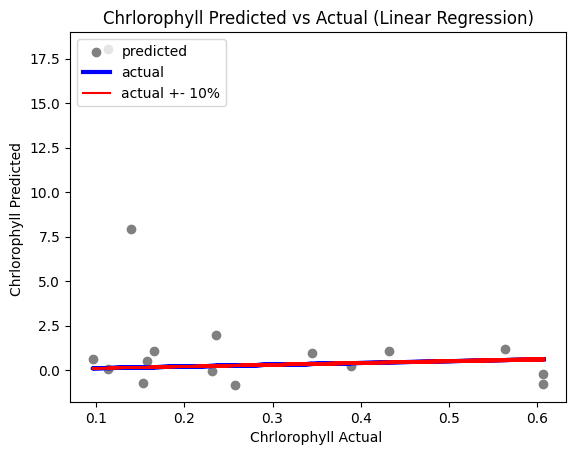

In [12]:
poly_x_values = poly_model.fit_transform(X_test)
poly_model.fit(poly_x_values, Y_test)
Y_pred = regression_model.predict(poly_x_values )
plt.scatter(Y_test,Y_pred,color='gray', label='predicted')
plt.plot(Y_test,Y_test,color='blue', linewidth=3, label='actual')
plt.plot(Y_test,Y_test*1.1,color='red', linewidth=1.5, label='actual +- 10%')
plt.plot(Y_test,Y_test*0.9,color='red', linewidth=1.5 )
plt.title('Chrlorophyll Predicted vs Actual (Linear Regression)')  
plt.xlabel('Chrlorophyll Actual ')  
plt.ylabel('Chrlorophyll Predicted ')  
plt.legend(loc="upper left")